<a href="https://colab.research.google.com/github/locacazador/citymobile_test/blob/master/taxi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используйте данные за декабрь 2019 и январь 2020 года.


1. Как стоимость поездки скоррелирована с другими факторами? Как вы это можете объяснить?
2. Найдите аномальные поездки. Почему именно эти поездки вы считаете аномальными?
3. Постройте распределение по стоимости поездок. Проверьте гипотезу о том, что оно имеет нормальное распределение. Как вы можете это объяснить?
4. Из данных постройте модель, которая описывает тариф (т.е. стоимость поездки от других факторов).
5. Используя модель из пункта выше ответьте на вопрос: были ли в какие-то дни (или временные промежутки) скидки или акции? И если то были, то как вы можете это объяснить



# Import data & get from csv

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
import scipy.stats as st 
from google.colab import drive
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive'

 123.rar		   payment.pdf
'Colab Notebooks'	   resnet50_out.csv
 diploma.pdf		   simple_cnn_baseline.csv
 DLS			   taxi.csv
 journey-springfield.zip   taxi.pickle
 mipt			   yellow_tripdata_2019-12.csv
 model_weights.pth	   yellow_tripdata_2020-01.csv


In [ ]:
data_december = pd.read_csv('/content/drive/MyDrive/yellow_tripdata_2019-12.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data_janruary = pd.read_csv('/content/drive/MyDrive/yellow_tripdata_2020-01.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
data = data_december.append(data_janruary)

# EDA & preprocessing

In [ ]:
assert data.shape[0] == data_december.shape[0] + data_janruary.shape[0]  and data.shape[1] == data_december.shape[1] == data_janruary.shape[1]

In [ ]:
del data_december
del data_janruary

In [ ]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5
1,1.0,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
2,1.0,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13301325 entries, 0 to 6405007
Data columns (total 18 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               float64
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          float64
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           float64
 10  fare_amount            float64
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             float64
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           float64
 17  congestion_surcharge   float64
dtypes: float64(13), int64(2), object(3)
memory usage: 1.9+ GB


In [ ]:
data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1.318487e+07,1.318487e+07,1.330132e+07,1.318487e+07,1.330132e+07,1.330132e+07,1.318487e+07,1.330132e+07,1.330132e+07,1.330132e+07,1.330132e+07,1.330132e+07,1.330132e+07,1.330132e+07,1.330132e+07
mean,1.667980e+00,1.533787e+00,2.952341e+00,1.062944e+00,1.641724e+02,1.620543e+02,1.285196e+00,1.315874e+01,1.111859e+00,4.923682e-01,2.218002e+00,3.692072e-01,2.979863e-01,1.917047e+01,2.275463e+00
std,4.709382e-01,1.163589e+00,5.890652e+01,8.757305e-01,6.581286e+01,7.013568e+01,4.815006e-01,1.099645e+02,1.259975e+00,7.301767e-02,2.820425e+00,1.740590e+00,3.383608e-02,1.103017e+02,7.356288e-01
min,1.000000e+00,0.000000e+00,-3.726453e+04,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.472000e+03,-2.700000e+01,-5.000000e-01,-2.008000e+02,-4.050000e+01,-3.000000e-01,-1.472800e+03,-2.500000e+00
25%,1.000000e+00,1.000000e+00,9.600000e-01,1.000000e+00,1.250000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.130000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,1.950000e+00,0.000000e+00,3.000000e-01,1.475000e+01,2.500000e+00
75%,2.000000e+00,2.000000e+00,3.000000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.450000e+01,2.500000e+00,5.000000e-01,2.950000e+00,0.000000e+00,3.000000e-01,2.075000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,2.102401e+05,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.984684e+05,1.130100e+02,3.080000e+01,1.100000e+03,9.105000e+02,3.000000e-01,3.984712e+05,3.000000e+00


In [ ]:
DATETIME_COLUMNS = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

In [ ]:
timezone_name = 'America/New_York'

In [ ]:
for col in DATETIME_COLUMNS:
  data[col] = pd.to_datetime(data[col])

In [ ]:
# Пропущенные значения
data.isna().sum()

VendorID                 116459
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          116459
trip_distance                 0
RatecodeID               116459
store_and_fwd_flag       116459
PULocationID                  0
DOLocationID                  0
payment_type             116459
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge          0
dtype: int64

In [ ]:
print(data.isna().sum()['VendorID'] / data.shape[0])

0.008755443536640147


In [ ]:
data[data['VendorID'].isna()]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
6845299,NaN,2019-12-01 11:29:00,2019-12-01 12:17:00,NaN,18.21,NaN,NaN,107,76,NaN,29.53,2.75,0.5,0.0,6.12,0.3,39.20,0.0
6845300,NaN,2019-12-01 11:40:42,2019-12-01 12:00:04,NaN,7.92,NaN,NaN,263,182,NaN,30.33,2.75,0.0,0.0,6.12,0.3,39.50,0.0
6845301,NaN,2019-12-01 11:00:00,2019-12-01 11:37:00,NaN,9.38,NaN,NaN,22,211,NaN,33.56,2.75,0.5,0.0,0.00,0.3,37.11,0.0
6845302,NaN,2019-12-01 11:43:00,2019-12-01 12:16:00,NaN,11.39,NaN,NaN,121,90,NaN,42.23,2.75,0.5,0.0,6.12,0.3,51.90,0.0
6845303,NaN,2019-12-01 11:01:35,2019-12-01 11:17:58,NaN,3.01,NaN,NaN,75,163,NaN,21.18,2.75,0.0,0.0,0.00,0.3,24.23,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6405003,NaN,2020-01-31 22:51:00,2020-01-31 23:22:00,NaN,3.24,NaN,NaN,237,234,NaN,17.59,2.75,0.5,0.0,0.00,0.3,21.14,0.0
6405004,NaN,2020-01-31 22:10:00,2020-01-31 23:26:00,NaN,22.13,NaN,NaN,259,45,NaN,46.67,2.75,0.5,0.0,12.24,0.3,62.46,0.0
6405005,NaN,2020-01-31 22:50:07,2020-01-31 23:17:57,NaN,10.51,NaN,NaN,137,169,NaN,48.85,2.75,0.0,0.0,0.00,0.3,51.90,0.0
6405006,NaN,2020-01-31 22:25:53,2020-01-31 22:48:32,NaN,5.49,NaN,NaN,50,42,NaN,27.17,2.75,0.0,0.0,0.00,0.3,30.22,0.0


Для понимания о величинах использовались описание [датасета](https://www1.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

В данном случае можно применить две стратегии. Первая заключается в том, чтобы каким-то образом заполнить данными. Допустим, что мы действительно сможем заполнить каким-то образом. Тем ни менее, определенно не факт, что не испортим данные, если будем случайным образом (медианой или средним значением). Более того, пропуски содержат приблизительно 0.9% данных, поэтому применим вторую стратегию - отбросим такую информацию.

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(13184866, 18)

In [ ]:
# check if there are no missing values after removing it
data.isna().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
store_and_fwd_flag       0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
dtype: int64

In [ ]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
0,1.0,2019-12-01 00:26:58,2019-12-01 00:41:45,1.0,4.2,1.0,N,142,116,2.0,14.5,3.0,0.5,0.0,0.0,0.3,18.3,2.5
1,1.0,2019-12-01 00:12:08,2019-12-01 00:12:14,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
2,1.0,2019-12-01 00:25:53,2019-12-01 00:26:04,1.0,0.0,1.0,N,145,145,2.0,2.5,0.5,0.5,0.0,0.0,0.3,3.8,0.0
3,1.0,2019-12-01 00:12:03,2019-12-01 00:33:19,2.0,9.4,1.0,N,138,25,1.0,28.5,0.5,0.5,10.0,0.0,0.3,39.8,0.0
4,1.0,2019-12-01 00:05:27,2019-12-01 00:16:32,2.0,1.6,1.0,N,161,237,2.0,9.0,3.0,0.5,0.0,0.0,0.3,12.8,2.5


Посмотрим детальнее на распределение данных по признакам. Обработаем заведомо неверные значения (ошибочные) путем исключения их из датасета. Также приведем признаки, которые должны содержать целочисленные значения, к соответствующему типу

In [ ]:
# int columns
INT_COLUMNS = ['VendorID', 'passenger_count', 'RatecodeID', 'PULocationID', 'DOLocationID', 'payment_type']

In [ ]:
data[INT_COLUMNS] = data[INT_COLUMNS].astype(np.int64)

In [ ]:
data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

In [ ]:
# Save csv (pickle??) to gdrive in order not to rerun preprocessing everytime
# data.to_csv('/content/drive/MyDrive/taxi.csv', index=False)


# data = pd.read_csv('/content/drive/MyDrive/taxi.csv', parse_dates = ['tpep_pickup_datetime', 'tpep_dropoff_datetime'])

In [ ]:
data.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
count,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07,1.318487e+07
mean,1.667980e+00,1.533787e+00,2.899569e+00,1.062944e+00,1.644183e+02,1.623319e+02,1.285196e+00,1.298932e+01,1.096852e+00,4.936646e-01,2.236968e+00,3.572071e-01,2.979711e-01,1.900764e+01,2.295475e+00
std,4.709382e-01,1.163589e+00,6.510600e+00,8.757305e-01,6.568355e+01,7.002877e+01,4.815006e-01,1.104274e+02,1.252851e+00,6.866321e-02,2.824207e+00,1.721354e+00,3.396974e-02,1.107658e+02,7.070883e-01
min,1.000000e+00,0.000000e+00,-2.301000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,-1.472000e+03,-2.700000e+01,-5.000000e-01,-2.008000e+02,-4.050000e+01,-3.000000e-01,-1.472800e+03,-2.500000e+00
25%,1.000000e+00,1.000000e+00,9.500000e-01,1.000000e+00,1.320000e+02,1.130000e+02,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,1.127000e+01,2.500000e+00
50%,2.000000e+00,1.000000e+00,1.600000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,9.500000e+00,5.000000e-01,5.000000e-01,1.950000e+00,0.000000e+00,3.000000e-01,1.475000e+01,2.500000e+00
75%,2.000000e+00,2.000000e+00,2.940000e+00,1.000000e+00,2.340000e+02,2.340000e+02,2.000000e+00,1.450000e+01,2.500000e+00,5.000000e-01,2.960000e+00,0.000000e+00,3.000000e-01,2.030000e+01,2.500000e+00
max,2.000000e+00,9.000000e+00,1.913018e+04,9.900000e+01,2.650000e+02,2.650000e+02,5.000000e+00,3.984684e+05,1.130100e+02,3.080000e+01,1.100000e+03,9.105000e+02,3.000000e-01,3.984712e+05,3.000000e+00


In [ ]:
data['VendorID'].unique()

array([1, 2])

In [ ]:
data['congestion_surcharge'].unique()

array([ 2.5 ,  0.  , -2.5 ,  0.75,  2.75,  0.5 , -1.5 ,  1.5 , -0.75,
        3.  ,  1.  ,  2.  ])

Базовая эвристика для отсечения очевидно некорректных данных:
все значения признаков должны быть больше нуля. Для ряда признаков достаточно нестрогого неравенства (например, congestion_surcharge)

In [ ]:
data['passenger_count'].value_counts()

1    9330618
2    2022170
3     553241
5     470580
4     288401
6     280079
0     239633
7         74
9         35
8         35
Name: passenger_count, dtype: int64

In [ ]:
data[data['passenger_count'] == 0]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
6,1,2019-12-01 00:14:19,2019-12-01 00:27:06,0,1.7,1,Y,164,163,2,10.0,3.0,0.5,0.00,0.0,0.3,13.80,2.5
7,1,2019-12-01 00:29:35,2019-12-01 00:32:29,0,0.5,1,N,79,224,1,4.0,3.0,0.5,1.55,0.0,0.3,9.35,2.5
8,1,2019-12-01 00:42:19,2019-12-01 00:50:34,0,1.4,1,N,79,107,2,7.5,3.0,0.5,0.00,0.0,0.3,11.30,2.5
14,1,2019-12-01 00:04:40,2019-12-01 00:31:27,0,17.4,2,N,132,141,1,52.0,2.5,0.5,5.53,0.0,0.3,60.83,2.5
95,1,2019-12-01 00:03:41,2019-12-01 00:11:44,0,2.1,1,N,186,125,1,8.0,3.0,0.5,2.35,0.0,0.3,14.15,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13184368,1,2020-01-31 23:10:10,2020-01-31 23:42:25,0,15.9,1,N,132,145,1,46.0,0.5,0.5,10.00,0.0,0.3,57.30,0.0
13184369,1,2020-01-31 23:51:26,2020-01-31 23:57:39,0,1.9,1,N,229,107,1,7.5,3.0,0.5,2.25,0.0,0.3,13.55,2.5
13184825,1,2020-01-31 23:51:21,2020-01-31 23:57:20,0,0.8,1,N,79,148,1,6.0,3.0,0.5,1.76,0.0,0.3,11.56,2.5
13184836,1,2020-01-31 23:43:08,2020-01-31 23:50:53,0,1.1,1,N,234,186,2,7.0,3.0,0.5,0.00,0.0,0.3,10.80,2.5


Какие-то странные поездки с 0 пассажиров. Несмотря на то, что таких данных много, придется для baseline их выкинуть, потому как непонятно, как поездка может быть без пассажиров.

In [ ]:
data[data['passenger_count'] == 0].shape[0] / data.shape[0]

0.018174852895736674

In [ ]:
data = data[data['passenger_count'] != 0]

Посмотрим распределение trip_distance

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


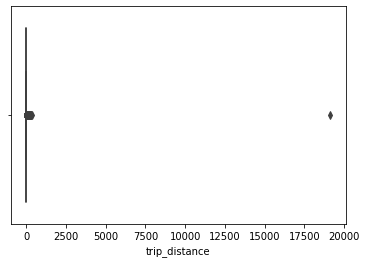

In [ ]:
sns.boxplot(data['trip_distance'])

Есть какая-то длинная поездка, которая очевидно некорректная. Посмотрим ранжированный ряд по дистанции поездки:

In [ ]:
data.sort_values('trip_distance', ascending=False)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge
704581,2,2019-12-04 10:20:13,2019-12-04 10:24:43,1,19130.18,5,N,224,224,2,11.00,0.0,0.0,0.00,0.00,0.0,11.00,0.0
5835474,2,2019-12-25 20:44:07,2019-12-26 03:10:41,2,363.13,5,N,132,265,2,400.00,0.0,0.5,0.00,46.34,0.3,447.14,0.0
2121568,2,2019-12-09 21:17:33,2019-12-10 02:55:18,4,323.81,5,N,130,265,2,400.00,0.0,0.0,0.00,126.00,0.3,526.30,0.0
6394756,1,2019-12-29 12:29:25,2019-12-29 12:34:03,1,300.80,1,N,231,125,2,5.50,2.5,0.5,0.00,0.00,0.3,8.80,2.5
8999979,2,2020-01-12 09:19:23,2020-01-12 13:49:59,4,262.88,5,N,132,265,1,600.00,0.0,0.0,0.00,55.55,0.3,658.35,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2851153,2,2019-12-12 19:58:10,2019-12-12 20:26:34,1,-9.94,5,N,228,233,1,29.22,0.0,0.5,7.73,6.12,0.3,48.32,2.5
8201012,2,2020-01-08 16:59:49,2020-01-08 17:43:23,1,-10.94,5,N,45,149,2,59.32,0.0,0.5,0.00,6.12,0.3,66.24,0.0
5494246,2,2019-12-23 14:07:46,2019-12-23 15:13:28,1,-19.23,5,N,86,82,2,56.72,0.0,0.5,0.00,0.00,0.3,57.52,0.0
7802868,2,2020-01-06 16:56:47,2020-01-06 17:54:29,1,-22.18,5,N,140,210,2,58.92,0.0,0.5,0.00,6.12,0.3,65.84,0.0


За 19 тысяч миль заплатили всего лишь 11 долларов, звучит нереалистично. Также мы видим, что, например, 300 миль были проеханы за 5 минут для объекта с id = 6394756. Уберем за одно и отрицательные значения, следуя базовой эвристике

In [ ]:
data = data[data['trip_distance'] > 0]

In [ ]:
data.drop(data[data['trip_distance'] > 370].index, inplace=True)

In [ ]:
data.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                   int64
trip_distance                   float64
RatecodeID                        int64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
dtype: object

In [ ]:
data = data[(data['tpep_pickup_datetime'].dt.date >= pd.Timestamp('2019-12-01')) & (data['tpep_dropoff_datetime'].dt.date <= pd.Timestamp('2020-01-31'))]

In [ ]:
# let's add some new feature - duration of trip in min & day of week
data['duration_min'] = data['tpep_dropoff_datetime'] - data['tpep_pickup_datetime']

In [ ]:
data['duration_min'] = data['duration_min'].dt.total_seconds() / 60

In [ ]:
data.drop(data[data['duration_min'] == 0].index, inplace=True)

In [ ]:
data['price_min'] = data['total_amount'] / data['duration_min']

In [ ]:
data.drop(data[(data['price_min'].isna())].index, inplace=True)

In [ ]:
data['miles_in_min'] = data['trip_distance'] / data['duration_min']

In [ ]:
data['day_of_week'] = data[['tpep_pickup_datetime', 'tpep_dropoff_datetime']].max(axis=1).dt.day_name()

In [ ]:
data['day_of_week']

0           Sunday
3           Sunday
4           Sunday
5           Sunday
9           Sunday
             ...  
13184860    Friday
13184861    Friday
13184862    Friday
13184863    Friday
13184864    Friday
Name: day_of_week, Length: 12809383, dtype: object

In [ ]:
def map_is_weekend(day_of_week: str) -> bool:
  if day_of_week == 'Sunday' or day_of_week == 'Saturday':
    return 1
  else:
    return 0

In [ ]:
data['is_weekend'] = data['day_of_week'].map(map_is_weekend)

Достаточно маловероятно, что поездка на такси могла длиться более 3-ех часов, поэтому предлагается ограничить сверху 180 минутами. Более того, таких значений не так много:

In [ ]:
sum(data['duration_min'] > 3 * 60)

31335

In [ ]:
data.drop(data[data['duration_min'] > 3 * 60].index, inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


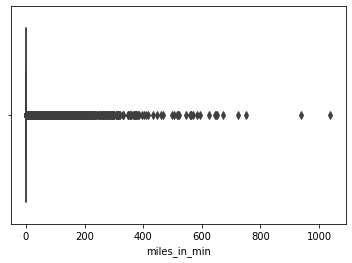

In [ ]:
# back to boxplot, lets take a look on it one more time
sns.boxplot(data['miles_in_min'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


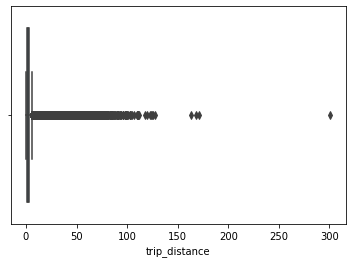

In [ ]:
sns.boxplot(data['trip_distance'])

По аналогии с длиной пути отсечем данные, у которых все признаки имеют отрицательные значения

In [ ]:
NUMERIC_COLUMNS = set(data.columns)
NON_NUMERICAL_COLUMNS = {'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'store_and_fwd_flag', 'day_of_week'}
NUMERIC_COLUMNS = NUMERIC_COLUMNS - NON_NUMERICAL_COLUMNS

In [ ]:
data = data[(data[NUMERIC_COLUMNS] >= 0).all(axis=1)]

In [ ]:
data['price_in_mile'] = data['total_amount'] / data['trip_distance']

Попробуем по введенной величине как-то обрезать очевидные ошибочные данные. Предлагается отсечь данные, которые имеют меньшую цену, чем 1 доллар в минуту и 1 доллар в милю одновременно. Данная эвристика не несет в себе строгого доказательства, а лишь основана на логике пользования такси

In [ ]:
data.drop(data[(data['price_in_mile'] < 1) & (data['price_min'] < 1)].index, inplace=True)

Рассмотрим еще значения fare_amount, то есть так называемого тарифа в зависимости от дистанции и времени поездки. С формальной точки зрении удалим те значения, которые больше порога (возьмем, если fare_amount > 100 одновременно с тем, что дистанция пути менее 0.3 мили)

In [ ]:
data[['fare_amount', 'trip_distance', 'total_amount']].sort_values('fare_amount', ascending=False)

,fare_amount,trip_distance,total_amount
513922,6012.5,0.20,6015.80
2522313,700.0,0.90,720.30
4742083,600.0,0.78,602.80
7616701,575.0,168.40,596.42
267425,544.5,117.83,561.92
...,...,...,...
3198914,0.0,0.10,0.30
3513702,0.0,12.70,110.00
10458468,0.0,8.90,0.30
10919413,0.0,7.00,14.05


In [ ]:
data.drop(data[(data['fare_amount'] > 100) & (data['trip_distance'] < 0.3)].index, inplace=True)

Итоговое преобразование должно заключаться в преобразовании флага store_and_fwd_flag для ухода от категориального признака в сторону вещественного. Произведем нужный маппинг

In [ ]:
data['store_and_fwd_flag'].value_counts()

N    12609539
Y      130298
Name: store_and_fwd_flag, dtype: int64

In [ ]:
# MAP from N to 0 and Y means 1
MAPPER = {'N': 0, 
          'Y': 1}

In [ ]:
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].map(MAPPER)

In [ ]:
data['store_and_fwd_flag'].value_counts()

0    12609539
1      130298
Name: store_and_fwd_flag, dtype: int64

Финально уберем наблюдения, в которых количество пассажиров больше 5, ведь речь идет о желтых такси, выглядит крайне сомнительным, что в них может поместиться более 5 человек.

In [ ]:
data.drop(data[data['passenger_count'] > 5].index, inplace=True)

# Корреляции признаков

In [ ]:
correlation_matrix = data.corr()

In [ ]:
correlation_matrix['total_amount'].sort_values(ascending=False)

total_amount             1.000000
fare_amount              0.977708
trip_distance            0.913877
duration_min             0.811089
tip_amount               0.706935
tolls_amount             0.675388
RatecodeID               0.276039
price_min                0.091237
price_in_mile            0.063365
miles_in_min             0.053170
VendorID                 0.019663
passenger_count          0.013623
extra                    0.007594
store_and_fwd_flag      -0.000840
improvement_surcharge   -0.008071
is_weekend              -0.018002
PULocationID            -0.080180
DOLocationID            -0.087884
payment_type            -0.116506
congestion_surcharge    -0.175442
mta_tax                 -0.308010
Name: total_amount, dtype: float64

Данные результаты не удивляют: тариф действительно должен радикальным образом регулировать финальную цену. Так как тариф зависим от продолжительности поездки и количества пройденного расстояния, то эти объясняется сильная корреляция между тоговой ценой и этими признаками. Аналогично и про tip_amount, tools_amount, которые по сути всегда прибавляются к fare_amount для определения total_amount. Также присутствует зависимость с RatecodeId, которая является неким кодом-рейтинга поездки, которые, очевидно, должны повышать цену (условно, Nassau or Westchester - далекие точки Нью-Йорка, поэтому тариф для них выше, ровно как и для аэропорта)

#  Распределение стоимости поездки

[(0.0, 60.0)]

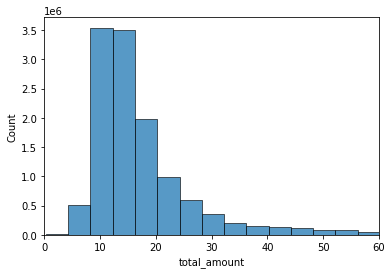

In [ ]:
hist_plot = sns.histplot(data=data[data['total_amount'] < 200], x='total_amount', bins = 50)
hist_plot.set(xlim=(0,60))

Распределение, конечно, не выглядит нормальным. Проверим это более строго с помощью методов.
## Критерий Шапиро-Уилка

In [ ]:
shapiro(data['total_amount'])

/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.6688827276229858, 0.0)

Тест Шапиро-Уилка непоказателен для N > 5000, поэтому воспользуемся другими проверками
## QQPLOT

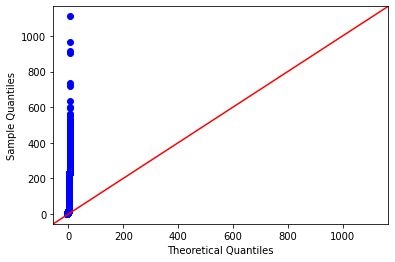

In [ ]:
sm.qqplot(data['total_amount'], line='45')
plt.show()

Как видно, мы не получили прямую, направленную под 45 градусов, значит, наше распределение далеко от нормального, что подтверждается и видом самого распределения.

## Normal-test
Проверка распределения по третьему и чертвертому моментам - ассиметрии и эксцессу соответственно.
Нулевая гипотеза заключается в том, что данные принадлежат нормальному распределению.

In [ ]:
print('p-value = {}'.format(st.normaltest(data['total_amount'])[1]))

p-value = 0.0


Отвергаем нулевую гипотезу и получаем, что данные не должны быть нормальными.

То есть наше значение стоимости поездки не является нормально распределенной величиной. По идее, это накладывает ограничения на работу статистических методов, которые мы можем применять. Тогда с формальной точки зрения, мы не можем использовать линейную модель для предсказания цены тарифа. 
В действительности, ненормальность распределения цены не вызывает удивления: цена зависит от множества факторов, включая выбросы (которые мы пытались удалить)

# Model evaluating
В качестве baseline возьмем модель бустинга Lightgbm (потому как даже линейная регрессия не считается из-за проблем с оперативкой даже на колабе) Для корректного использования алгоритма произведем нормализацию нужных признаков.  Преобразуем данные с помощью тренировочной выборки и тестовую выборку для того, чтобы не было leak-ов.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.linear_model import ElasticNetCV, SGDRegressor
import lightgbm as lgb

In [ ]:
data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,duration_min,price_min,miles_in_min,day_of_week,is_weekend,price_in_mile
0,1,2019-12-01 00:26:58,2019-12-01 00:41:45,1,4.2,1,0,142,116,2,14.5,3.0,0.5,0.00,0.0,0.3,18.30,2.5,14.783333,1.237880,0.284104,Sunday,1,4.357143
3,1,2019-12-01 00:12:03,2019-12-01 00:33:19,2,9.4,1,0,138,25,1,28.5,0.5,0.5,10.00,0.0,0.3,39.80,0.0,21.266667,1.871473,0.442006,Sunday,1,4.234043
4,1,2019-12-01 00:05:27,2019-12-01 00:16:32,2,1.6,1,0,161,237,2,9.0,3.0,0.5,0.00,0.0,0.3,12.80,2.5,11.083333,1.154887,0.144361,Sunday,1,8.000000
5,1,2019-12-01 00:58:51,2019-12-01 01:08:37,2,1.0,1,0,161,230,2,6.5,3.0,0.5,0.00,0.0,0.3,10.30,2.5,9.766667,1.054608,0.102389,Sunday,1,10.300000
9,1,2019-12-01 00:19:48,2019-12-01 00:24:18,1,0.9,1,0,148,4,1,5.5,3.0,0.5,1.85,0.0,0.3,11.15,2.5,4.500000,2.477778,0.200000,Sunday,1,12.388889


In [ ]:
# We need to drop some features in order to train 
# Drop: tpep_pickup_datetime, tpep_dropoff_datetime, price_in_mile
# because 2 last features are just part of total_amount - target
# target: total_amount
X = data.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'price_in_mile', 'day_of_week', 'total_amount', 'price_min'], axis=1)
y  = data['total_amount']

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

Необходимо откладывать и валидационную выборку для того, чтобы выбрать лучшую модель. Но так как модель обучаем одну (baseline) без перебора гиперпараметров, то можно сразу оценить качество на тестовой выборке.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': -1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
}

In [ ]:
train_dataset = lgb.Dataset(data=X_train, label=y_train)

In [ ]:
model = lgb.train(params=params, train_set=train_dataset, num_boost_round=300)

In [ ]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [ ]:
mean_squared_error(y_test, y_pred)

0.8221954541622083

In [ ]:
del train_dataset
del X_train
del y_train
del y_pred
del X_test

По ощущению, скидки могут быть в дни 24-25 декабря. 1-2 января, 18 января и 25 января (см. график ниже)

In [ ]:
condition_christmas = (data['tpep_dropoff_datetime'].dt.date >= pd.Timestamp('2019-12-24')) & (data['tpep_dropoff_datetime'].dt.date <= pd.Timestamp('2019-12-25'))
condition_new_year = (data['tpep_dropoff_datetime'].dt.date >= pd.Timestamp('2020-01-01')) & (data['tpep_dropoff_datetime'].dt.date <= pd.Timestamp('2020-01-02'))
condition_18_jan = (data['tpep_dropoff_datetime'].dt.date >= pd.Timestamp('2020-01-18')) & (data['tpep_dropoff_datetime'].dt.date < pd.Timestamp('2020-01-19'))
condition_25_jan = (data['tpep_dropoff_datetime'].dt.date >= pd.Timestamp('2020-01-25')) & (data['tpep_dropoff_datetime'].dt.date < pd.Timestamp('2020-01-26'))

In [ ]:
X_predict = X[condition_christmas | condition_new_year | condition_18_jan | condition_25_jan]

In [ ]:
y_predict = y[condition_christmas | condition_new_year | condition_18_jan | condition_25_jan]

In [ ]:
X_predict.shape[0]

949941

In [ ]:
X_train = X[~(condition_christmas | condition_new_year | condition_18_jan | condition_25_jan)]

In [ ]:
y_train = y[~(condition_christmas | condition_new_year | condition_18_jan | condition_25_jan)]

In [ ]:
X_train.shape[0]

11512672

In [ ]:
assert X_train.shape[0] + X_predict.shape[0] == X.shape[0]

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_predict_scaled = scaler.transform(X_predict)

In [ ]:
full_dataset = lgb.Dataset(data=X_train_scaled, label=y_train)

In [ ]:
model = lgb.train(params=params, train_set=full_dataset, num_boost_round=300)

In [ ]:
del X_train
del X_train_scaled
del y_train

## Попробуем линейную модель.

In [ ]:
linear_model = SGDRegressor(l1_ratio=0.2)

In [ ]:
linear_model.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.2,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [ ]:
y_pred_linear = linear_model.predict(X_test)

In [ ]:
y_pred_linear

array([ 8.3639039 , 18.30183299, 16.31869802, ..., 10.23592159,
       11.31675853, 26.68382719])

In [ ]:
mean_squared_error(y_test, y_pred_linear)

0.07416057953185538

In [ ]:
del y_pred_linear

## Проба пера

In [ ]:
data['day_of_year'] = data['tpep_dropoff_datetime'].dt.date

In [ ]:
data['day_of_year']

0           2019-12-01
3           2019-12-01
4           2019-12-01
5           2019-12-01
9           2019-12-01
               ...    
13184860    2020-01-31
13184861    2020-01-31
13184862    2020-01-31
13184863    2020-01-31
13184864    2020-01-31
Name: day_of_year, Length: 12462613, dtype: object

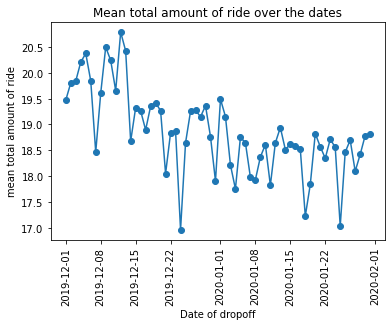

In [ ]:
plt.plot(data.groupby('day_of_year')['total_amount'].agg(np.mean), marker='o')
plt.xlabel('Date of dropoff')
plt.xticks(rotation=90)
plt.ylabel('mean total amount of ride')
plt.title('Mean total amount of ride over the dates')
plt.show()

In [ ]:
total_amount_pred = model.predict(X_predict_scaled, num_iteration=model.best_iteration)
# total_amount_pred = linear_model.predict(X)

In [ ]:
total_amount_pred

array([31.87673568, 15.91078481, 25.74166498, ..., 12.32649836,
       10.93802971, 21.05316247])

In [ ]:
sum(total_amount_pred < 100)

948420

In [ ]:
# delete all not needed data (i.e. training, testing, ...)
del X_train
del y_train
del X_test 
del y_test
del full_dataset
del y_pred

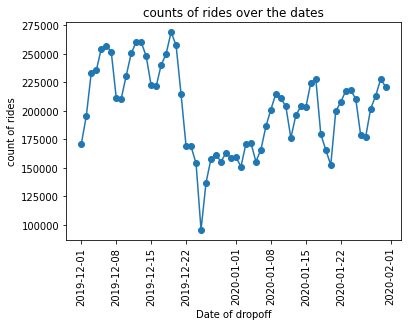

In [ ]:
plt.plot(data.groupby('day_of_year')['total_amount'].agg('count'), marker='o')
plt.xlabel('Date of dropoff')
plt.xticks(rotation=90)
plt.ylabel('count of rides')
plt.title('counts of rides over the dates')
plt.show()

Предсказанные:

In [ ]:
data.loc[X_predict.index, 'total_amount_pred'] = total_amount_pred

In [ ]:
total_amount_over_days = data.groupby('day_of_year')[['total_amount', 'total_amount_pred']].agg(np.mean)

In [ ]:
total_amount_over_days.dropna()

,total_amount,total_amount_pred
day_of_year,,
2019-12-24,16.958765,16.955688
2019-12-25,18.644199,18.650050
2020-01-01,19.489798,19.479883
2020-01-02,19.154842,19.145697
2020-01-18,17.223730,17.244056
2020-01-25,17.030530,17.032097


Действительно можно наблюдать малое падение цены (скидка) 25 декабря, которое возможно связано с праздником Рождества у католиков. А также, скорее всего, скидка была 18 января. В то время происходили массовые мероприятия - "женский марш" в США, в том числе и Нью-Йорке, где собиралось рекордное число жителей города. Вполне вероятно, что ради такого мероприятия (чтобы получить большее число клиентов) такси сделали небольшую скидку (есть небольшой локальный максимум)